In [22]:
# imports an stuff
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision

import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots

In [23]:
# prep the images
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# setup batch size and labels
batch_size = 64
num_labels = 12

# directory with data
dataset_path = '/Users/matteop/Desktop/ECE176/FinalProject/data'

# load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transformations)

# split sizes
train_size = int(0.707 * len(dataset))  # 70.7% for training
val_size = int(0.142 * len(dataset))    # 14.2% for validation
test_size = len(dataset) - train_size - val_size  # The rest for testing

# display sizes so we can make sure theyre multiples of batch size
print(f'Number of training samples: {train_size}')
print(f'Number of validation samples: {val_size}')
print(f'Number of testing samples: {test_size}')

# split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of training samples: 640
Number of validation samples: 128
Number of testing samples: 138


In [24]:
# check if GPU is available
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [25]:
# display data

In [26]:
# test the model on the validation set
def testVal(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(images)
            _, predicted = scores.max(1)
            num_correct += (predicted == labels).sum()
            num_samples += predicted.size(0)
    
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [27]:
# traiin model
def train(model, optimizer, num_epochs=1):
    model = model.to(device=device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # get training accuracy over epochs
        for i, (images, labels) in enumerate(train_loader):
            model.train()
            images = images.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)

            scores = model(images)
            loss_t = loss_fn(scores, labels)
            train_loss += loss_t.item()
            if i == len(train_loader) - 1:
                print('Epoch %d/%d, Training Loss = %.4f' % (epoch+1, num_epochs, loss_t.item()))

            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
        
        train_losses.append(train_loss / len(train_loader))

        # get validation accuracy over epochs
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device=device, dtype=dtype)
                labels = labels.to(device=device, dtype=torch.long)
                scores = model(images)
                loss_v = loss_fn(scores, labels)

                val_loss += loss_v.item()

        val_losses.append(val_loss / len(val_loader))
        

    return train_losses, val_losses

In [28]:
# ResNet10 model
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

class Resnet_Block(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super(Resnet_Block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
            
        self.downsample = downsample
        
    def forward(self, x):
        identity = x 
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

class ResNet10(nn.Module):
    def __init__(self, block, num_classes):
        super(ResNet10, self).__init__()
        self.in_channels=64
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = block(self.in_channels, 64)
        
        self.layer2 = block(64, 128, downsample=nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128)))

        self.layer3 = block(128, 256, downsample=nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(256)))

        self.layer4 = block(256, 512, downsample=nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(512)), stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = flatten(x)
        x = self.fc(x)
        return x

In [29]:
# setup model and optimizer
loss_fn = nn.CrossEntropyLoss()

model = ResNet10(Resnet_Block, num_labels)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [30]:
# train model and get training and validation losses
train_loss, val_loss = train(model, optimizer, num_epochs=20)
print('Finished Training')

Epoch 1/20, Training Loss = 2.1485
Epoch 2/20, Training Loss = 1.7851
Epoch 3/20, Training Loss = 1.4895
Epoch 4/20, Training Loss = 1.3033
Epoch 5/20, Training Loss = 1.1763
Epoch 6/20, Training Loss = 1.1776
Epoch 7/20, Training Loss = 1.0312
Epoch 8/20, Training Loss = 0.9580
Epoch 9/20, Training Loss = 0.7277
Epoch 10/20, Training Loss = 0.7883
Epoch 11/20, Training Loss = 0.6671
Epoch 12/20, Training Loss = 0.7932
Epoch 13/20, Training Loss = 0.6461
Epoch 14/20, Training Loss = 0.5294
Epoch 15/20, Training Loss = 0.3829
Epoch 16/20, Training Loss = 0.4569
Epoch 17/20, Training Loss = 0.4415
Epoch 18/20, Training Loss = 0.4289
Epoch 19/20, Training Loss = 0.2718
Epoch 20/20, Training Loss = 0.2580
Finished Training


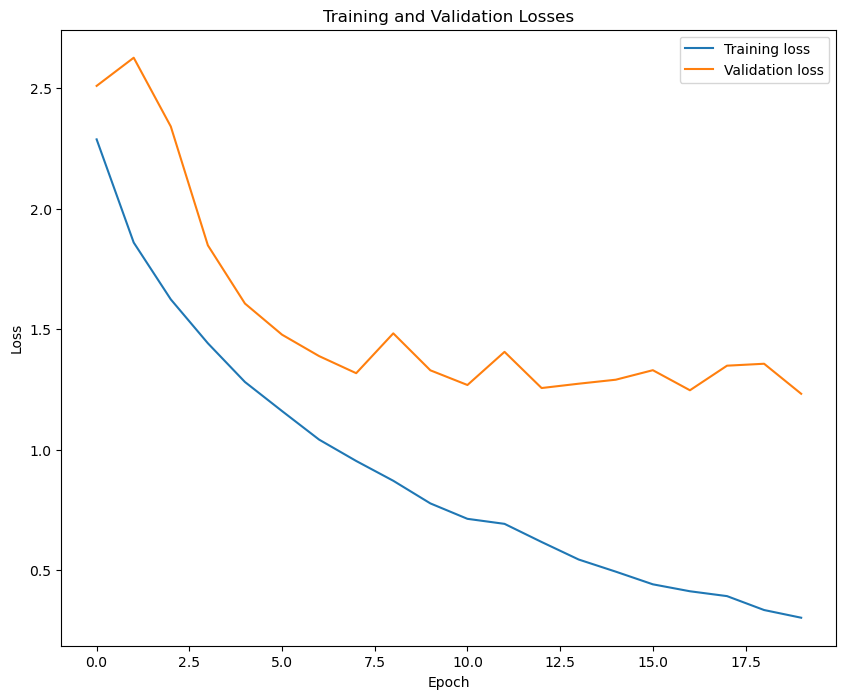

In [31]:
#plot the training and validation losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [32]:
print('Validation Accuracy')
testVal(val_loader, model)

Validation Accuracy
Got 84 / 128 correct (65.62)
